Ref:

https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

https://www.kaggle.com/code/sunaysawant/air-passengers-time-series-arima/notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

### Data

Reference: https://www.kaggle.com/datasets/rakannimer/air-passengers

This dataset contains the number of air travel passengers per month from the start of 1949 to the end of 1960.

In [2]:
df_orig = pd.read_csv('data/AirPassengers.csv')
df_orig

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df_orig = pd.read_csv('data/AirPassengers.csv')
df_orig['Passengers'] = df_orig['Passengers'].astype(int)
df_orig['Month'] = pd.to_datetime(df_orig['Month'], infer_datetime_format=True)
df = df_orig.copy()
df = df.set_index(['Month'])
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


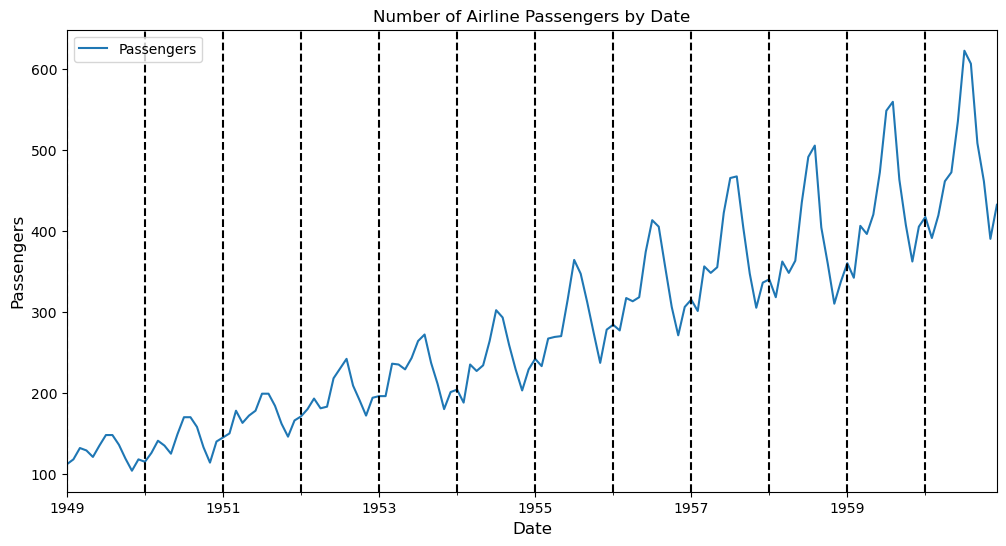

In [4]:
df_orig.plot(x='Month', y='Passengers', figsize=(12,6))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
for i in range(12):
    plt.axvline(x=f'{str(1949+i)}-01-01', color='black', linestyle='--')
plt.show()

**Rolling Statistics**:

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

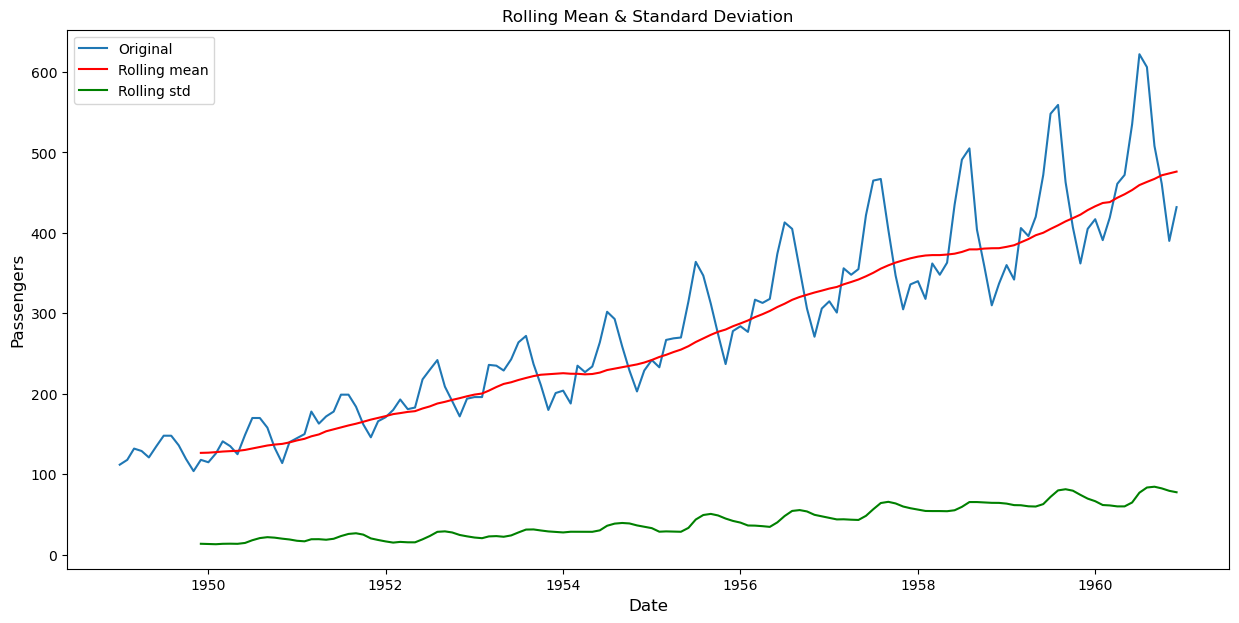

In [5]:
plt.figure(figsize=(15,7))
plt.plot(df["Passengers"], label='Original')
plt.plot(df["Passengers"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df["Passengers"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Passengers', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

**Augmented Dickey–Fuller Test**

In [6]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lags Used                       13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


**Seasonal decompose**

In [8]:
def seasonal_decompose (df, model):
    decomposition = sm.tsa.seasonal_decompose(df, model=model, extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

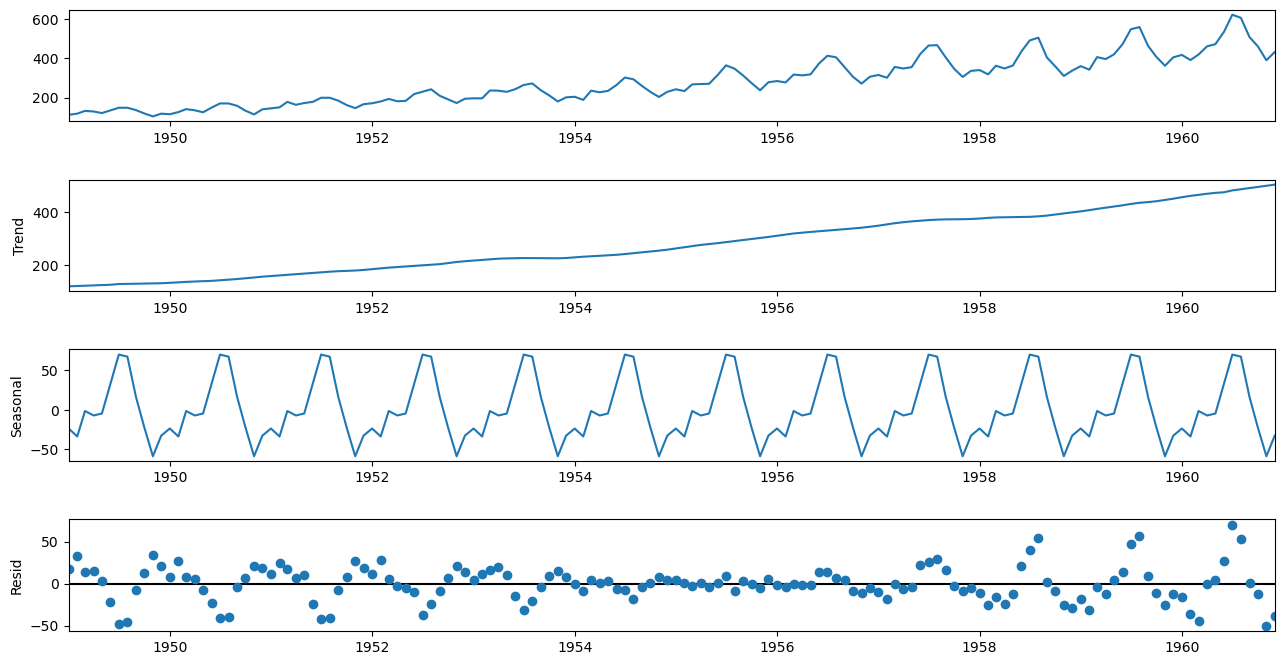

In [9]:
trend, seasonal, residual = seasonal_decompose(df, model='additive')

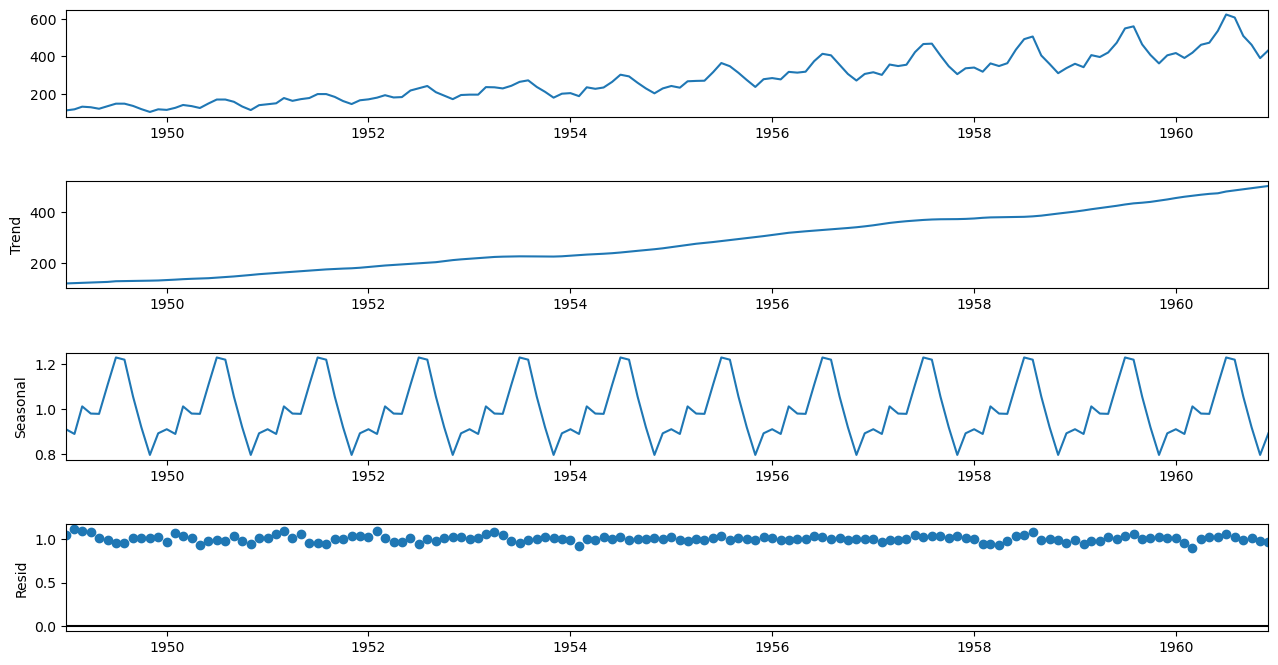

In [10]:
trend, seasonal, residual = seasonal_decompose(df, model='multiplicative')

In order to run the ARIMA model, the seasonal component needs to be removed:

## ARIMA

<AxesSubplot:xlabel='Month'>

<Figure size 1800x600 with 0 Axes>

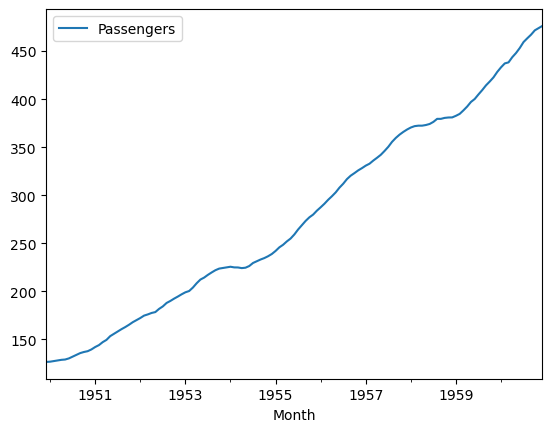

In [11]:
arima_df = df.rolling(window=12).mean().dropna()
plt.figure(figsize=(18, 6))
arima_df.plot()

In [12]:
df_train = arima_df[:int(len(arima_df)*0.95)]
df_test = arima_df[int(len(arima_df)*0.95):]

### Finding the value of the d parameter 

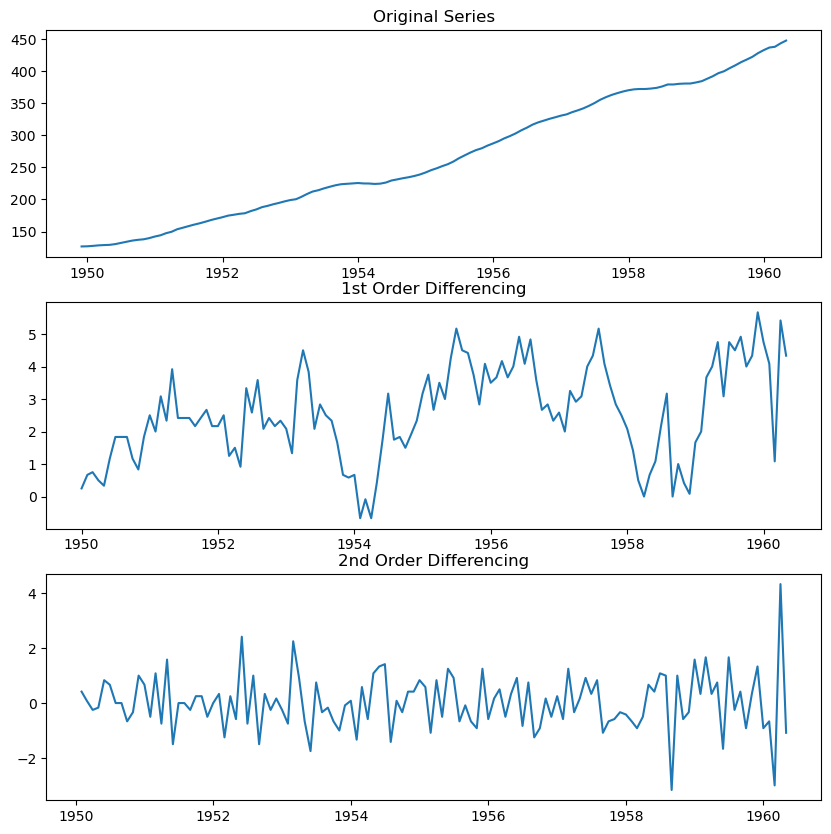

In [13]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(df_train.Passengers)
ax1.set_title('Original Series')

# 1st Differencing
ax2.plot(df_train.Passengers.diff(periods=1))
ax2.set_title('1st Order Differencing')

# 2nd Differencing
ax3.plot(df_train.Passengers.diff(periods=1).diff(periods=1))
ax3.set_title('2nd Order Differencing')
plt.show()

In [14]:
ADF_test(df_train.Passengers.diff(periods=1).dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -3.129825
p-value                          0.024423
Lags Used                        1.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [15]:
ADF_test(df_train.Passengers.diff(periods=1).diff(periods=1).dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.519629e+01
p-value                        5.914251e-28
Lags Used                      0.000000e+00
Number of Observations Used    1.230000e+02
Critical Value (1%)           -3.484667e+00
Critical Value (5%)           -2.885340e+00
Critical Value (10%)          -2.579463e+00
dtype: float64


Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

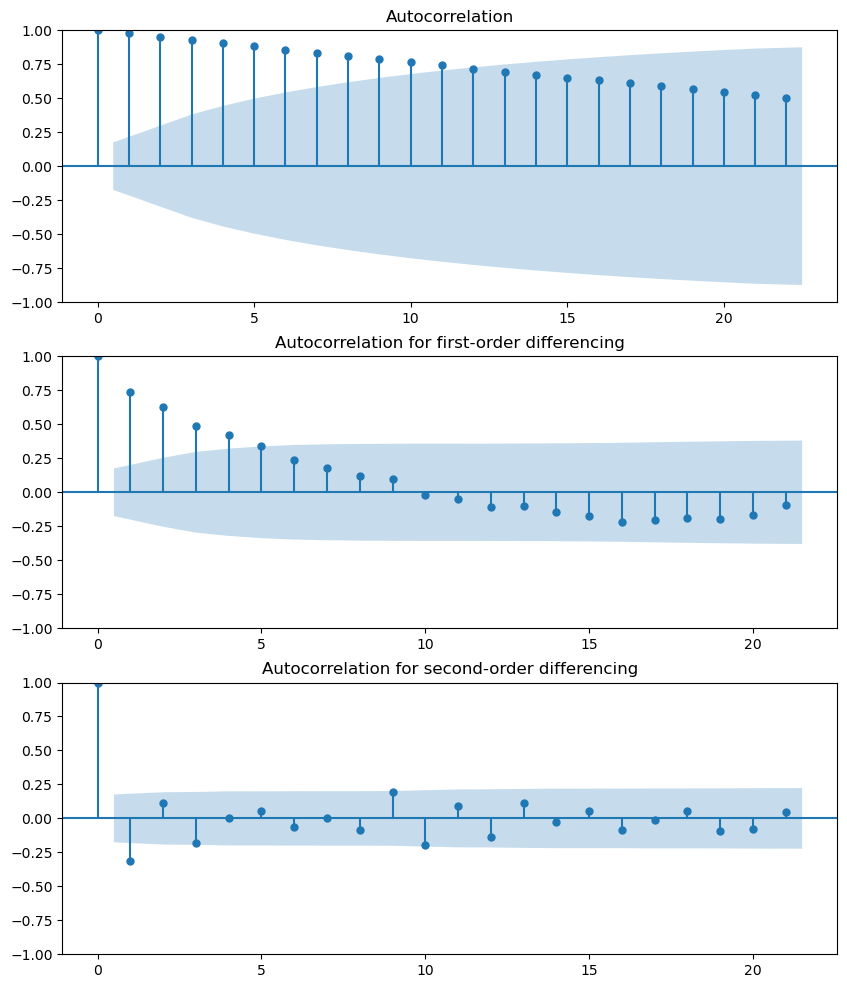

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(df_train.Passengers, ax=ax1)
_ = plot_acf(df_train.Passengers.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(df_train.Passengers.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

### Finding the value of the p parameter

/home/javiferfer/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


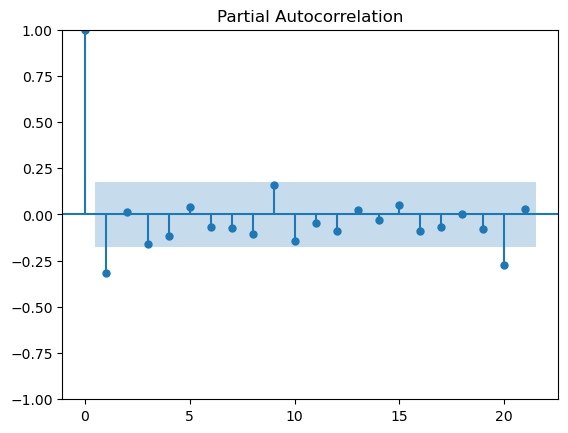

In [17]:
_ = plot_pacf(df_train.Passengers.diff().diff().dropna())

Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1. 

### Finding the value of the q parameter

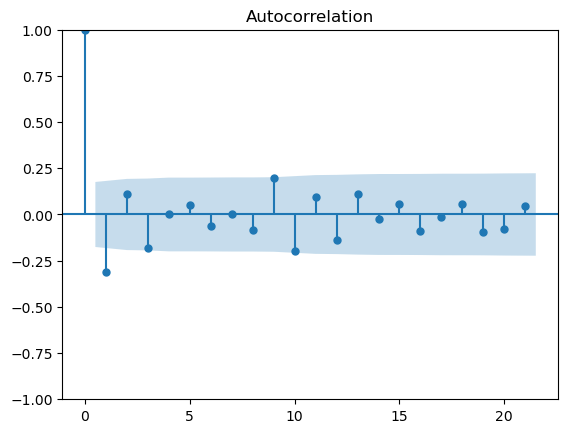

In [18]:
_ = plot_acf(df_train.Passengers.diff().diff().dropna())

## SARIMA

In [19]:
df_train = df[:int(len(df)*0.95)]
df_test = df[int(len(df)*0.95):]

In [20]:
sarima = pm.auto_arima(
    start_p=0,
    max_p=5,
    start_q=0,
    max_q=5,
    max_d=3,
    start_P=0,
    max_P=5,
    start_Q=0,
    max_Q=5,
    max_D=3,
    m=12,
    y=df_train
)
sarima

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [21]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  136
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -475.208
Date:                            Sun, 28 Apr 2024   AIC                            954.416
Time:                                    15:22:24   BIC                            960.041
Sample:                                01-01-1949   HQIC                           956.701
                                     - 04-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3239      0.073     -4.430      0.000      -0.467      -0.181
sigma2       132.7122     13.951      9.513      0.000     105.369     160.055
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 9.87
Prob(Q):                              0.94   Prob(JB):                         0.01
Heteroskedasticity (H):               2.01   Skew:                             0.05
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The prediction error is: 2.61%


/tmp/ipykernel_60217/833164598.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_plot = df_plot.append(data_test.join(df_pred))


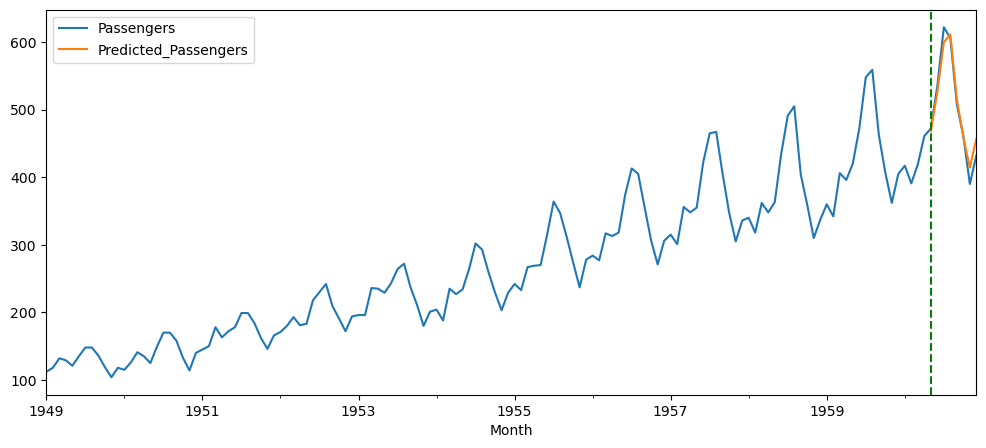

In [22]:
def predict_and_plot_model(model, data_train, data_test):
    df_pred = model.predict(n_periods=len(data_test))
    df_pred.name = 'Predicted_Passengers'

    df_plot = data_train.copy()
    df_plot['Predicted_Passengers'] = [np.nan for _ in range(len(data_train))]
    df_plot = df_plot.append(data_test.join(df_pred))

    print('The prediction error is: {:.2f}%'.format(
        mean_absolute_percentage_error(
            y_true=data_test['Passengers'].values,
            y_pred=df_pred.values
        )*100
    ))
    df_plot.plot(figsize=(12, 5))
    plt.axvline(df_pred.index.min(), 0,1, color='green', linestyle='--');

predict_and_plot_model(sarima, df_train, df_test)